In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

parent_path = os.path.dirname(os.getcwd())
target_dir = f'{parent_path}/model_to_graph'
sys.path.append(target_dir)

# import Relay_compiler
import graph_visualization as gv
import hardware as hw
import dijkstra as dijk
import stacked_graph as sg
import testing as test
import data_collection as dc
from main import forward


/home/rjtomich/miniconda3/envs/schedule/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regular Inference (gpt2)

In [2]:
def generate_token(model_name, prompt):
    # model = AutoModelForCausalLM.from_pretrained(model_name, torchscript=True)
    # tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    tokenizer.pad_token = tokenizer.eos_token
    streamer = TextStreamer(tokenizer)

    model.tie_weights()

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]



    model = model.eval()  # Change to eval mode

    # gen_tokens = model.generate(input_ids, do_sample=False, max_new_tokens=10, streamer=streamer)
    gen_tokens = model.generate(
                                    input_ids,
                                    attention_mask=attention_mask,
                                    do_sample=False,
                                    max_length=15,
                                    pad_token_id=tokenizer.pad_token_id,
                                    streamer=streamer
                                )

    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

    return input_ids, gen_tokens, gen_text
    return int(gen_tokens[0][-1])

model_name = 'gpt2'
prompt = "my favorite music is"

prompt_tokens, gen_tokens, gen_text = generate_token(model_name, prompt)
print(f'{"Prompt Tokens:":<20} {prompt_tokens}')
print(f'{"Generated Tokens:":<20} {gen_tokens}')

my favorite music is "The Last of Us" by the Grateful Dead.
Prompt Tokens:       tensor([[1820, 4004, 2647,  318]])
Generated Tokens:    tensor([[ 1820,  4004,  2647,   318,   366,   464,  4586,   286,  4021,     1,
           416,   262, 44249,  5542,    13]])


# Export the model to TVM Relay IR

Precomputed to save time (takes about 1 minuet for gpt2)

In [3]:
# model_onnx, input_ids = transformer_torch_to_onnx(model_name, prompt, save=False)
# lib = onnx_to_relay(model_onnx, input_ids, write=True, model_name=model_name, opt_level=0)

# setting up enviroment

In [10]:
relay_path = "gpt2_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
# hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))


available_hardware = hw.initilize_hardware(hardware)


optimization = 'time'
# optimization = 'energy'

# Graph IR


 3 / 28


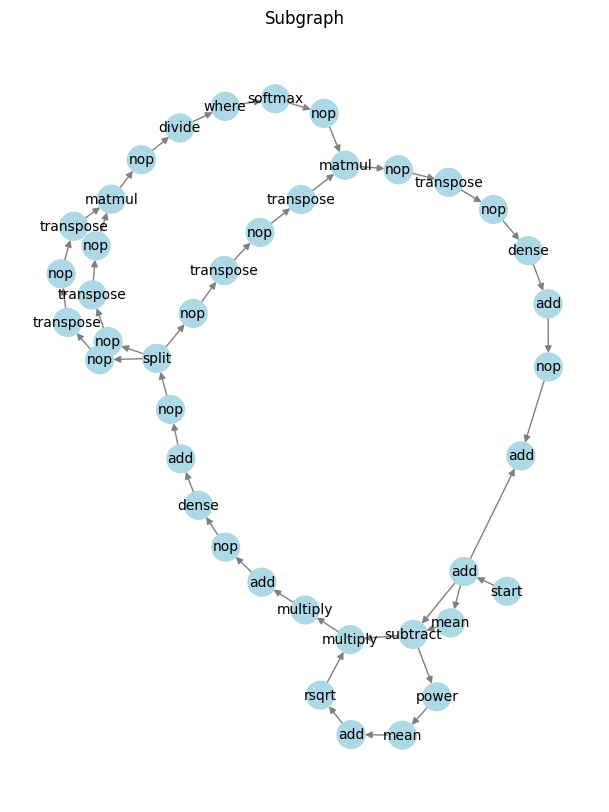

In [11]:
def draw_subgraphs(subgraph, sub = False):
    fig, ax = plt.subplots(figsize=(10, 10))

    gv.adj_to_graph(subgraph, ax=ax, layout='kk', title=f'Subgraph')
    # plt.tight_layout()
    plt.show()

subgraph_to_plot = 3

print()

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE, config=None
)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)

print(f' 3 / {len(flat_subgraphs)}')


draw_subgraphs(flat_subgraphs[subgraph_to_plot])


# End to End

In [12]:

forward(relay_path, optimization, available_hardware, profiles = False, get_step_times=False)


---------- INFO ----------
WEIGHT_VARIABLE='time'
Photonic Selected: 0 / 0
{'get_dram', 'start'}
Makespan: 0.06409 s
Number of Nodes: 1108
---------- ---- ----------


break down to the MAC level for comparison 
Make a bar plot
